### Importing packages and reading data

In [ ]:
import numpy as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM , Embedding , Bidirectional , Input , Dropout
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

In [ ]:
train_data = pd.read_csv('train.csv')

In [ ]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Getting information about data

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
train_data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

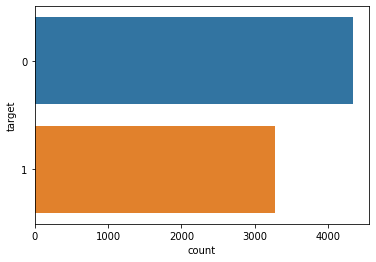

In [ ]:
sns.countplot(y=train_data.target)

In [ ]:
train_data.isna().sum() / (train_data.isna().sum() + train_data.notna().sum())*100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

Yes there is missing data and the percentage differs from a column to another as example the most missing column is location and the percentage is 33.27%

Getting the most 15 occured locations

In [ ]:
print(train_data['location'].value_counts()[:15])

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
Name: location, dtype: int64


Getting the most 15 occured keywords

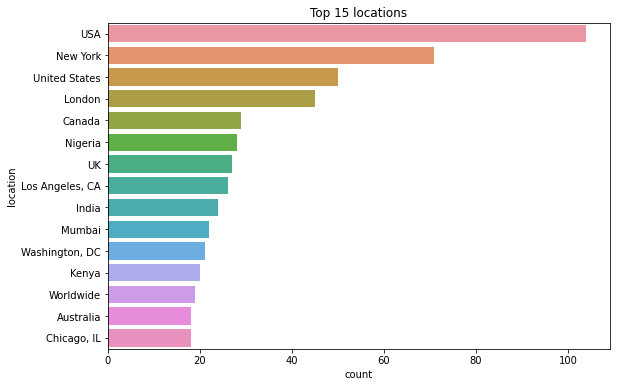

In [ ]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_data.location, order = train_data.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

In [ ]:
print(train_data['keyword'].value_counts()[:15])

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
Name: keyword, dtype: int64


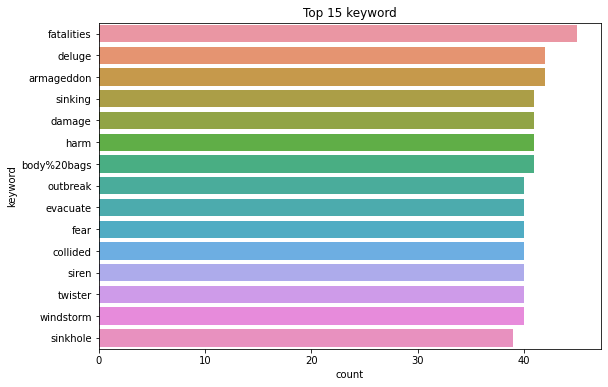

In [ ]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_data.keyword, order = train_data.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keyword')
plt.show()

In [ ]:
nltk.download('stopwords') #Downloading stop words to use it
stop_words = stopwords.words('english')
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

### Preprocessing and cleaning text

In [ ]:
def cleanText(text):
    """
    Input :- Text
    Output :- The same text but after cleaning it.
    """
    text=re.sub(r'#[a-zA-Z0-9|_]*=','',text)   # remove hashtage 
    text=re.sub(r'@[a-zA-Z0-9|_]*','',text)    # remove user name 
    text=re.sub(r'https?:\/\/\S+','',text)     # remove hyperlink 
    text=re.sub(r'\W',' ',text)                # remove emotions
    text=re.sub('\d+','',text)                 # remove digits
    text=re.sub(r'^\s+','',text)               # remove space in front of text 
    text=re.sub(r'\s+$','',text)               #remove space in tail text
    return text

Getting the most common word and the most common stop word

In [ ]:
sentences = train_data['text']
sentences = sentences.apply(lambda x : cleanText(x)) #Cleaning the text first
sentences = sentences.apply(lambda x : x.lower())    #Making sure it counts the capital letters like the small ones
sentences = sentences.apply(lambda x : x.split())    #Splitting the sentence into some words

all_words = {}
all_stop_words = {}
for sentence in sentences:
  for word in sentence:

    if word in stop_words :
      if word in all_stop_words:
        all_stop_words[word] += 1
      else :
        all_stop_words[word] = 1                    

    if word not in stop_words :
      if word in all_words :
        all_words[word] += 1
      else:
        all_words[word] = 1

most_common_stop_word = [(key,value) for key,value in all_stop_words.items() if value == max(all_stop_words.values())]
most_common_word = [(key,value) for key,value in all_words.items() if value == max(all_words.values())]
print(f"The most common stop word is :- {most_common_stop_word}")
print(f"The most common word is :- {most_common_word}")

The most common stop word is :- [('the', 3276)]
The most common word is :- [('like', 348)]


In [ ]:
all_words_sorted = sorted(all_words.items(), key=lambda x: x[1], reverse=True)
all_words_sorted[0:20]

[('like', 348),
 ('û_', 344),
 ('amp', 344),
 ('fire', 254),
 ('get', 229),
 ('new', 226),
 ('via', 220),
 ('news', 200),
 ('people', 199),
 ('one', 196),
 ('video', 165),
 ('disaster', 158),
 ('emergency', 158),
 ('police', 143),
 ('would', 137),
 ('u', 137),
 ('body', 131),
 ('time', 130),
 ('still', 129),
 ('us', 126)]

In [ ]:
def process_text(sentence):
  """
  Input :- Sentence
  Output :- The same sentence after getting cleaned , splitted , stemmed and without the stop words
  """
  sentence = cleanText(sentence)
  sentence = sentence.lower()
  sentence = sentence.split()                                    # Splitting the sentence into words
  words = [word for word in sentence  if word not in stop_words] # remove stop words
  return words 

In [ ]:
train_data['text'] = train_data['text'].apply(lambda x : process_text(x))

In [ ]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


In [ ]:
len(all_words)

14017

### Tokenization and padding

In [ ]:
tokenizer = Tokenizer(num_words = 15000) #Bigger than number of unique words
tokenizer.fit_on_texts(train_data['text']) #Fitting tokenizer into the texts
sequences = tokenizer.texts_to_sequences(train_data['text']) #Converting the text to numbers
print(sequences)

[[4182, 715, 153, 62, 1432, 4183, 20], [100, 4, 133, 629, 6164, 6165, 1054], [1555, 1433, 1730, 558, 6166, 1556, 154, 1730, 558, 1228, 947], [9, 4184, 1319, 154, 1228, 21], [29, 1055, 227, 6167, 1731, 166, 1319, 6168, 96], [2637, 292, 21, 1229, 716, 6169, 445, 993, 293, 4, 4185, 1319], [119, 12, 717, 190, 1056, 682, 155, 1557, 6170, 889, 2213, 1320], [126, 1732, 35, 4, 4186], [13, 154, 1141, 468, 718, 604], [2214, 407, 147, 159], [446, 9, 514, 167, 335, 515], [719, 426, 2638, 127, 2639, 3246, 559, 516, 108, 426, 2638, 216, 216, 6171, 155], [2640, 155, 1434, 6172, 2638, 469, 580, 4187], [119, 4188, 754, 1558, 4188], [128, 96, 311, 2641, 51, 26, 228], [28], [42, 4189], [217, 1559], [51, 653], [6173], [2642], [832, 427], [42, 6174], [2215, 24], [6175], [72, 1733, 129], [1142, 69, 259], [42, 1945], [6176], [1, 4190], [199], [2643, 1734, 535], [181, 755, 833, 717, 1057, 33], [6177, 228, 8, 2216, 683, 168, 535, 994], [1435, 168, 535], [1560, 605, 83, 834, 69, 148, 535], [4191, 1946, 102, 324

In [ ]:
max_len = 0
for sentence in train_data['text']:
   new_len = len(sentence)
   if new_len > max_len:
     max_len = new_len
print(max_len)
count = 0
count2 = 0
for sentence in train_data['text']:
   new_len = len(sentence)
   if new_len > 12:
     count += 1
   else:
     count2 += 1
print(count)
print(count2)

23
1272
6341


In [ ]:
padded_seq = pad_sequences(sequences ,truncating = 'post', maxlen = 20 , padding = 'post') 
print(padded_seq)

[[4182  715  153 ...    0    0    0]
 [ 100    4  133 ...    0    0    0]
 [1555 1433 1730 ...    0    0    0]
 ...
 [ 626  509  491 ...    0    0    0]
 [  14  981  436 ...    0    0    0]
 [ 115  110  444 ...    0    0    0]]


### Model development

In [ ]:
Target = train_data['target']
x_train, x_val, y_train, y_val = train_test_split(padded_seq, Target, test_size=0.3, random_state=42)

In [ ]:
inputs = Input(shape = (20,) , dtype = "int32")
x = Embedding(15000 , 128)(inputs)
x = LSTM(128,return_sequences = True ,kernel_regularizer=l2(0.01))(x)
x = Dropout(.3)(x)
x = LSTM(64,kernel_regularizer=l2(0.01))(x)
x = Dropout(.3)(x)
outputs = Dense(1 , activation = 'sigmoid')(x)
model = keras.Model(inputs , outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 20, 128)           1920000   
                                                                 
 lstm_2 (LSTM)               (None, 20, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 20, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65  

In [ ]:
model.compile( 'adam' , 'binary_crossentropy' , metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(x_train , y_train , batch_size = 64 , epochs = 40, validation_data=(x_val,y_val) , callbacks=[callback])

Epoch 1/40
84/84 [==============================] - 5s 21ms/step - loss: 1.9600 - accuracy: 0.7046 - val_loss: 0.7402 - val_accuracy: 0.8039
Epoch 2/40
84/84 [==============================] - 1s 9ms/step - loss: 0.4083 - accuracy: 0.8885 - val_loss: 0.4894 - val_accuracy: 0.7968
Epoch 3/40
84/84 [==============================] - 1s 9ms/step - loss: 0.2085 - accuracy: 0.9403 - val_loss: 0.5534 - val_accuracy: 0.7426
Epoch 4/40
84/84 [==============================] - 1s 9ms/step - loss: 0.1552 - accuracy: 0.9580 - val_loss: 0.6876 - val_accuracy: 0.7767
Epoch 5/40
84/84 [==============================] - 1s 10ms/step - loss: 0.1370 - accuracy: 0.9651 - val_loss: 0.6052 - val_accuracy: 0.7618
Epoch 6/40
84/84 [==============================] - 1s 10ms/step - loss: 0.1156 - accuracy: 0.9732 - val_loss: 0.6488 - val_accuracy: 0.7758


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

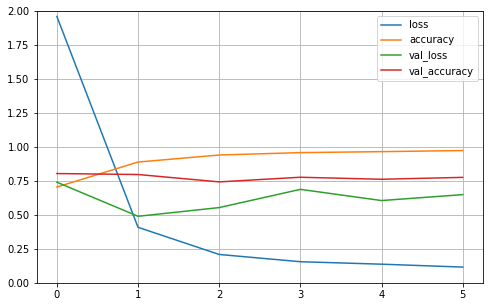

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
model.save('GradProj.h5')

In [ ]:
!ls

drive  GradProj  GradProj.h5  sample_data  train.csv


In [ ]:
model = keras.models.load_model("GradProj.h5")

In [ ]:
train_score = model.evaluate(x_val, y_val)

72/72 [==============================] - 2s 4ms/step - loss: 0.6488 - accuracy: 0.7758


### Testing model

In [ ]:
test_data = pd.read_csv('test.csv')
test_data['text'] = test_data['text'].apply(lambda x:process_text(x))
test_sequence = tokenizer.texts_to_sequences(test_data['text'])
test_seq = pad_sequences(test_sequence ,truncating = 'post', maxlen = 20 , padding = 'post')
test_acc = model.predict(test_seq)

In [ ]:
test_acc[:10]

array([[0.10283706],
       [0.9807012 ],
       [0.994159  ],
       [0.6098171 ],
       [0.9952429 ],
       [0.9395654 ],
       [0.07703369],
       [0.03901822],
       [0.01312502],
       [0.01625811]], dtype=float32)

In [ ]:
test_acc = test_acc.round()

In [ ]:
test_acc[:10]

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
test_data['Predicted'] = test_acc

In [ ]:
test_data.head()

,id,keyword,location,text,Predicted
0,0,NaN,NaN,"[happened, terrible, car, crash]",0.0
1,2,NaN,NaN,"[heard, earthquake, different, cities, stay, s...",1.0
2,3,NaN,NaN,"[forest, fire, spot, pond, geese, fleeing, acr...",1.0
3,9,NaN,NaN,"[apocalypse, lighting, spokane, wildfires]",1.0
4,11,NaN,NaN,"[typhoon, soudelor, kills, china, taiwan]",1.0
